---
# <font color="DarkBlue"><b><center>Escuela Politécnica Nacional</center></b></font>
---

## <font color="DarkGreen"><center>Ransomware dynamics: Mitigating personal data exfiltration through the SCIRAS lens</font>

## <font color="DarkGreen"><center>Dynamics of privacy malware</font>

## <font color="DarkGreen"><center>Traditional machine learning algorithms</font>

**Author:** David Cevallos-Salas, José Estrada-Jiménez, Danny S. Guamán, Luis Felipe Urquiza

**Date:** 2024-10-17

**Google Colab Link:**
https://colab.research.google.com/drive/1uwKCCKrNINGLHxopbiTWtgmEcTwNVgm2

In [ ]:
# Importing libraries
from os import X_OK
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.utils import to_categorical,plot_model
from sklearn.pipeline import Pipeline as skPipeline
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
import sklearn.metrics as mt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
import imblearn.metrics as imt
import zipfile
import os

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!git clone https://github.com/dcevallossalas/sanrap_sciras4

node = "win7"
y = np.array([])
first = True
first1 = True

families = os.listdir("/content/sanrap_sciras4/" + node + "/")

for family in families:
  annotations = os.listdir("/content/sanrap_sciras4/" + node + "/" + family)
  for annotation in annotations:
    files =  os.listdir("/content/sanrap_sciras4/" + node + "/" + family + "/" + annotation)
    for file in files:
      zipped = False
      if file.endswith(".zip"):
        zipped = True
        path1 = "/content/sanrap_sciras4/" + node + "/" + family + "/" + annotation + "/" + file
        path2 = "/home"
        with zipfile.ZipFile(path1, 'r') as zip_ref:
          zip_ref.extractall(path2)

        file = file.replace(".zip",".csv")

      if file.endswith("write.csv"):
        if zipped:
          data = pd.read_csv(path2 + "/original/win7-120gb-ssd/"+ family + "/" + annotation+"/" + file)
        else:
          data = pd.read_csv("/content/sanrap_sciras4/" + node + "/" + family + "/" + annotation+"/" + file)

        x1 = data.drop(data.columns[0],axis=1).to_numpy()

        if first:
          x = x1
          first = False
        else:
          x = np.concatenate((x,x1))

        n = len(x1)

        if annotation.startswith("TeslaCrypt"):
          code = 1
        elif annotation.startswith("WannaCry"):
          code = 2
        elif annotation.startswith("Cerber"):
          code = 3
        elif annotation.startswith("Gand"):
          code = 4
        elif annotation.startswith("Ryuk"):
          code = 5
        elif annotation.startswith("Sodi"):
          code = 6
        elif annotation.startswith("Dark"):
          code = 7
        else:
          code = 0

        if first1:
          y = np.full(n,code)
          first1 = False
        else:
          y = np.concatenate((y,np.full(n,code)))

# Number of metrics
num_metrics = 8

# Number of classes
num_classes = 8

# Definition of labels
labels = [
    "Benign",
    "TeslaCrypt",
    "WannaCry",
    "Cerber",
    "GandCrab-v4",
    "Ryuk",
    "Sodinokibi",
    "Darkside"
]


Cloning into 'sanrap_sciras4'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 384 (delta 1), reused 130 (delta 1), pack-reused 254 (from 1)
Receiving objects: 100% (384/384), 1.03 GiB | 18.34 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Updating files: 100% (240/240), done.


In [ ]:
# Representative random stratified sample
x, x1, y, y1 = train_test_split(x, y, train_size=0.06, shuffle=True, random_state = 1234, stratify=y)

# Splitting (training and test balanced sets definitions)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, shuffle=True, random_state = 1234, stratify = y)

# Visualize general shapes on screen
print("Shape x (features):", x.shape)
print("Shape y (families labels): ", y.shape)

# Number of samples per category
print("Benign: " + str(np.sum(y==0)))
print("TeslaCrypt: " + str(np.sum(y==1)))
print("WannaCry: " + str(np.sum(y==2)))
print("Cerber: " + str(np.sum(y==3)))
print("GandCrab-v4: " + str(np.sum(y==4)))
print("Ryuk: " + str(np.sum(y==5)))
print("Sodinokibi: " + str(np.sum(y==6)))
print("Darkside: " + str(np.sum(y==7)))

Shape x (features): (3384659, 5)
Shape y (families labels):  (3384659,)
Benign: 2256493
TeslaCrypt: 53162
WannaCry: 298152
Cerber: 73382
GandCrab-v4: 218547
Ryuk: 188011
Sodinokibi: 166910
Darkside: 130002


In [ ]:
def visualizeResults(x_test, y_test, pipeline):
  # Test evaluation
  y_test_pred_proba = pipeline.predict_proba(x_test)

  y_test_pred = pipeline.predict(x_test)
  f1score = mt.f1_score(y_test, y_test_pred, average="weighted")
  acc = mt.accuracy_score(y_test, y_test_pred)
  preci = mt.precision_score(y_test, y_test_pred, average="weighted")
  recall = mt.recall_score(y_test, y_test_pred, average="weighted")

  # Classification report
  print("Classification report")
  report = mt.classification_report(y_test, y_test_pred)
  print(report)

  # Confusion matrix
  # TN FP
  # FN TP
  # print("Confusion matrix")
  # print(y_test_pred)
  cm = mt.confusion_matrix(y_test, y_test_pred)
  pd_cm = pd.DataFrame(cm,
             columns=labels,
             index=labels)
  print(pd_cm)

  # Display confusion matrix using ConfusionMatrixDisplay
  # g_cm = mt.ConfusionMatrixDisplay(cm,display_labels=labels).plot()
  # plt.show(g_cm)

  # Display confusion matrix using Heat Map
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax,
    square=True,
    cmap="Blues",
    linewidths=0.2,
    annot_kws={"fontsize":5.5})
  ax.set_xlabel("Predicted values", fontsize=8)
  ax.set_ylabel("True values", fontsize=8)
  ax.xaxis.set_ticklabels(labels, fontsize=8)
  ax.yaxis.set_ticklabels(labels, fontsize=8)
  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=8)
  plt.yticks(rotation=0)
  plt.xticks(rotation=90)

  # ROC curves
  import colorcet as cc

  palette = sns.color_palette(cc.glasbey, num_classes)
  palette1 = sns.color_palette(cc.glasbey, 16)
  palette[0] = palette1[10]
  palette[1] = palette1[0]

  t_test_oneh = to_categorical(y_test,num_classes)
  fig, ax = plt.subplots()
  auc = 0

  for i in np.arange(0,num_classes):
    fpr, tpr, thresholds = mt.roc_curve(t_test_oneh[:, i], y_test_pred_proba[:, i])
    auc_value = round(mt.auc(fpr, tpr),4)
    auc = auc+auc_value
    plt.plot(fpr, tpr,color=palette[i],label=labels[i] + " (AUC="+str(auc_value)+")")

  plt.plot([0,1],[0,1],"k--")
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="best", prop={'size': 6})
  plt.grid()
  plt.show()

  auc = auc/num_classes

  # Test evaluation results
  print("Test evaluation results: recall =", recall, ", F1 =", f1score, ", acc =", acc, ", precision =", preci, "auc =", auc)


In [ ]:
# Function for calculating Metrics - Multiclass classifier
def calculateMetrics(ytrue, ypred, yproba, labels, pictures=False):
  if pictures:
    print("Matriz de confusión")
    cm = mt.confusion_matrix(ytrue, ypred)

    # Matrix confusion
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax,
      square=True,
      cmap="Blues",
      linewidths=0.2,
      annot_kws={"fontsize":5.5})
    ax.set_xlabel("Predicted category", fontsize=8)
    ax.set_ylabel("True category", fontsize=8)
    ax.xaxis.set_ticklabels(labels, fontsize=8)
    ax.yaxis.set_ticklabels(labels, fontsize=8)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=8)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()

  # Calculating metrics
  precision = mt.precision_score(ytrue, ypred, average="micro")
  recall = mt.recall_score(ytrue, ypred, average="micro")
  f1score = mt.f1_score(ytrue, ypred, average="micro")
  accuracy = mt.accuracy_score(ytrue, ypred)
  error = 1-accuracy
  specificity = imt.specificity_score(ytrue, ypred, average="micro")
  fprm = 1-specificity

  # ROC curve
  numClases = len(labels)

  if pictures:
    numClases_color = numClases

    if numClases < numClases:
      numClases_color = numClases

    palette = sns.color_palette(cc.glasbey, numClases_color)
    palette = [palette[10],palette[0]]+palette[1:10]+palette[11:]
    fig, ax = plt.subplots()

  ytrue_oneh = to_categorical(ytrue,num_classes)
  auc=0

  for i in np.arange(0,numClases):
    fpr, tpr, thresholds = mt.roc_curve(ytrue_oneh[:, i], yproba[:, i], drop_intermediate=False)
    auc_value = round(mt.auc(fpr, tpr),4)
    auc = auc + auc_value
    if pictures:
      plt.plot(fpr, tpr, color=palette[i], label=labels[i] + " (AUC="+str(auc_value)+")")

  if pictures:
    plt.plot([0,1], [0,1], "--k")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc="lower right", prop={'size': 6})
    plt.grid()
    plt.show()

  auc = auc/numClases

  # Present metrics
  print("------------------------------")
  print("Valores de métricas obtenidas:")
  print("------------------------------")
  print("precision:", precision)
  print("recall:", recall)
  print("f1-score:", f1score)
  print("accuracy:", accuracy)
  print("error:", error)
  print("specificity:", specificity)
  print("false positive rate:", fprm)
  print("auc:", auc)

  return np.array([[precision],[recall],[f1score],[accuracy],[error],[specificity],[fprm],[auc]])

In [ ]:
def visualizeResultsGeneral(x_test, y_test, pipeline):
  # Test evaluation
  # y_test_pred_proba = pipeline.predict_proba(x_test)

  y_test_pred = pipeline.predict(x_test)
  f1score = mt.f1_score(y_test, y_test_pred, average="weighted")
  acc = mt.accuracy_score(y_test, y_test_pred)
  preci = mt.precision_score(y_test, y_test_pred, average="weighted")
  recall = mt.recall_score(y_test, y_test_pred, average="weighted")

  # Classification report
  print("Classification report")
  report = mt.classification_report(y_test, y_test_pred)
  print(report)

  # Confusion matrix
  # TN FP
  # FN TP
  # print("Confusion matrix")
  # print(y_test_pred)

  cm = mt.confusion_matrix(y_test, y_test_pred)
  pd_cm = pd.DataFrame(cm,
             columns=labels,
             index=labels)
  # print(pd_cm)

  # Display confusion matrix using ConfusionMatrixDisplay
  # g_cm = mt.ConfusionMatrixDisplay(cm,display_labels=labels).plot()
  # plt.show(g_cm)

  # Display confusion matrix using Heat Map
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax,
    square=True,
    cmap="Blues",
    linewidths=0.2,
    annot_kws={"fontsize":5.5})
  ax.set_xlabel("Predicted values", fontsize=8)
  ax.set_ylabel("True values", fontsize=8)
  ax.xaxis.set_ticklabels(labels, fontsize=8)
  ax.yaxis.set_ticklabels(labels, fontsize=8)
  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=8)
  plt.yticks(rotation=0)
  plt.xticks(rotation=90)

  # Test evaluation results
  print("Test evaluation results: recall =", recall, ", F1 =", f1score, ", acc =", acc, ", precision =", preci)

# Decision Tree

In [ ]:
# General
np.random.seed(1)

pipeline_nsm = skPipeline([
        ("scaler", StandardScaler()),
        ("clf", tree.DecisionTreeClassifier(random_state=0))])

# Repeated kfold cross validation definition
rkfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=45)

# Parameters of grid
param_grid = {
                "clf__criterion": ["gini","entropy"],
                "clf__max_depth": [1,3]
              }

# #####################
# GridSearchCV
# #####################
print("------------------------------")
print("Decision tree")
print("------------------------------")
search = GridSearchCV(pipeline_nsm, param_grid, cv=rkfold, scoring='f1_micro', verbose=4)
result = search.fit(x_train, y_train)

# Training with best hyperparameters
pipeline_nsm.set_params(
    clf__criterion = result.best_params_["clf__criterion"],
    clf__max_depth = result.best_params_["clf__max_depth"]
    )

print(f"Best result at validation set: {result.best_score_} with hyperparameters {result.best_params_}")

print("Retraining:")
pipeline_nsm.fit(x_train, y_train)




------------------------------
Decision tree
------------------------------
Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END clf__criterion=gini, clf__max_depth=1;, score=0.676 total time=   3.8s
[CV 2/10] END clf__criterion=gini, clf__max_depth=1;, score=0.676 total time=   2.6s
[CV 3/10] END clf__criterion=gini, clf__max_depth=1;, score=0.676 total time=   2.6s
[CV 4/10] END clf__criterion=gini, clf__max_depth=1;, score=0.676 total time=   2.6s
[CV 5/10] END clf__criterion=gini, clf__max_depth=1;, score=0.676 total time=   3.6s
[CV 6/10] END clf__criterion=gini, clf__max_depth=1;, score=0.676 total time=   2.7s
[CV 7/10] END clf__criterion=gini, clf__max_depth=1;, score=0.676 total time=   2.7s
[CV 8/10] END clf__criterion=gini, clf__max_depth=1;, score=0.676 total time=   2.8s
[CV 9/10] END clf__criterion=gini, clf__max_depth=1;, score=0.676 total time=   2.9s
[CV 10/10] END clf__criterion=gini, clf__max_depth=1;, score=0.676 total time=   3.1s
[CV 1/10] EN

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', DecisionTreeClassifier(max_depth=3, random_state=0))])

Classification report
              precision    recall  f1-score   support

           0       0.89      0.94      0.91    451299
           1       0.00      0.00      0.00     10632
           2       0.84      0.69      0.76     59631
           3       0.00      0.00      0.00     14676
           4       0.24      0.82      0.38     43710
           5       0.00      0.00      0.00     37602
           6       0.00      0.00      0.00     33382
           7       0.00      0.00      0.00     26000

    accuracy                           0.74    676932
   macro avg       0.25      0.31      0.26    676932
weighted avg       0.68      0.74      0.70    676932

             Benign  TeslaCrypt  WannaCry  Cerber  GandCrab-v4  Ryuk  \
Benign       426420           0      7228       0        17651     0   
TeslaCrypt     1457           0        62       0         9113     0   
WannaCry       9372           0     41218       0         9041     0   
Cerber         6761           0        

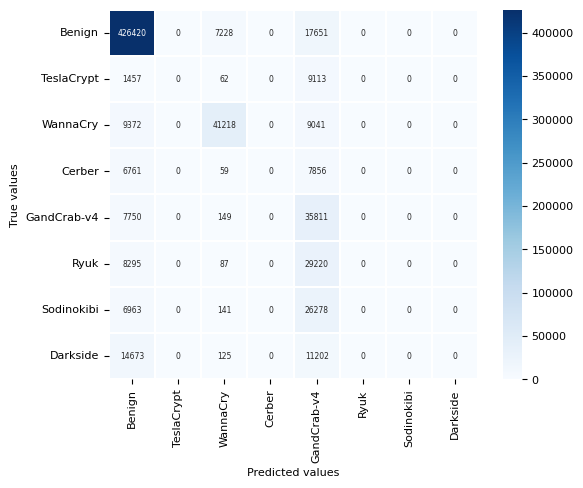

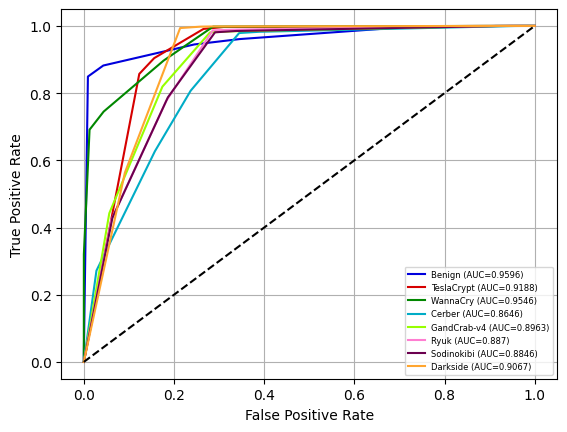

Test evaluation results: recall = 0.7437216736688471 , F1 = 0.7005718668603802 , acc = 0.7437216736688471 , precision = 0.680000336467105 auc = 0.909025


In [ ]:
# Visualize general shapes on screen
visualizeResults(x_test, y_test, pipeline_nsm)

# Random Forest

In [ ]:
# General
np.random.seed(1)

pipeline_nsm = skPipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=0))])

# Repeated kfold cross validation definition
rkfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=45)

# Parameters of grid
param_grid = {
                "clf__n_estimators": [10,20],
                "clf__criterion": ["gini","entropy"],
                "clf__max_depth": [3,5]
              }

# #####################
# GridSearchCV
# #####################
print("------------------------------")
print("Random Forest")
print("------------------------------")
search = GridSearchCV(pipeline_nsm, param_grid, cv=rkfold, scoring='f1_micro', verbose=4)
result = search.fit(x_train, y_train)

# Training with best hyperparameters
pipeline_nsm.set_params(
    clf__n_estimators = result.best_params_["clf__n_estimators"],
    clf__criterion = result.best_params_["clf__criterion"],
    clf__max_depth = result.best_params_["clf__max_depth"]
    )

print(f"Best result at validation set: {result.best_score_} with hyperparameters {result.best_params_}")

print("Retraining:")
pipeline_nsm.fit(x_train, y_train)

------------------------------
Random Forest
------------------------------
Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10] END clf__criterion=gini, clf__max_depth=3, clf__n_estimators=10;, score=0.717 total time=  23.9s
[CV 2/10] END clf__criterion=gini, clf__max_depth=3, clf__n_estimators=10;, score=0.717 total time=  23.2s
[CV 3/10] END clf__criterion=gini, clf__max_depth=3, clf__n_estimators=10;, score=0.717 total time=  25.0s
[CV 4/10] END clf__criterion=gini, clf__max_depth=3, clf__n_estimators=10;, score=0.717 total time=  23.5s
[CV 5/10] END clf__criterion=gini, clf__max_depth=3, clf__n_estimators=10;, score=0.717 total time=  23.9s
[CV 6/10] END clf__criterion=gini, clf__max_depth=3, clf__n_estimators=10;, score=0.717 total time=  23.0s
[CV 7/10] END clf__criterion=gini, clf__max_depth=3, clf__n_estimators=10;, score=0.717 total time=  23.7s
[CV 8/10] END clf__criterion=gini, clf__max_depth=3, clf__n_estimators=10;, score=0.717 total time=  23.8s
[CV 9/1

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        n_estimators=20, random_state=0))])

Classification report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91    451299
           1       0.52      0.39      0.45     10632
           2       0.90      0.69      0.78     59631
           3       0.90      0.17      0.28     14676
           4       0.34      0.71      0.46     43710
           5       0.30      0.01      0.01     37602
           6       0.45      0.04      0.08     33382
           7       0.25      0.07      0.11     26000

    accuracy                           0.78    676932
   macro avg       0.57      0.38      0.39    676932
weighted avg       0.75      0.78      0.73    676932

             Benign  TeslaCrypt  WannaCry  Cerber  GandCrab-v4  Ryuk  \
Benign       442314        1214      3777      67         3605    58   
TeslaCrypt     2584        4124        63      81         3566     1   
WannaCry      13893        2193     41261     126         1820    17   
Cerber         7497           0        

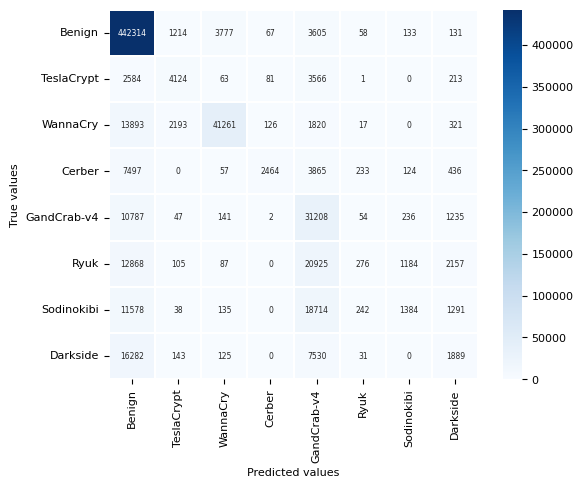

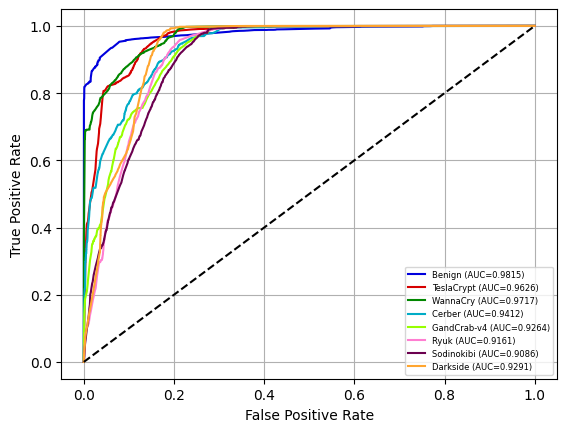

Test evaluation results: recall = 0.7754397782938316 , F1 = 0.7294757295053697 , acc = 0.7754397782938316 , precision = 0.7475002442211992 auc = 0.94215


In [ ]:
visualizeResults(x_test, y_test, pipeline_nsm)

# SVM Classifier

In [ ]:
# General
np.random.seed(1)

pipeline_nsm = skPipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(max_iter=500, random_state=0))])

# Repeated kfold cross validation definition
rkfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=45)

# Parameters of grid
param_grid = {
                "clf__kernel": ["rbf","linear"]
              }

# #####################
# GridSearchCV
# #####################
print("------------------------------")
print("SVC results")
print("------------------------------")
search = GridSearchCV(pipeline_nsm, param_grid, cv=rkfold, scoring='f1_micro', verbose=4)
result = search.fit(x_train, y_train)

# Training with best hyperparameters
pipeline_nsm.set_params(
    clf__kernel = result.best_params_["clf__kernel"]
    )

print(f"Best result at validation set: {result.best_score_} with hyperparameters {result.best_params_}")




------------------------------
SVC results
------------------------------
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END ..................clf__kernel=rbf;, score=0.532 total time=  18.6s
[CV 2/10] END ..................clf__kernel=rbf;, score=0.537 total time=  16.3s
[CV 3/10] END ..................clf__kernel=rbf;, score=0.535 total time=  16.4s
[CV 4/10] END ..................clf__kernel=rbf;, score=0.612 total time=  15.5s
[CV 5/10] END ..................clf__kernel=rbf;, score=0.610 total time=  15.7s
[CV 6/10] END ..................clf__kernel=rbf;, score=0.475 total time=  15.3s
[CV 7/10] END ..................clf__kernel=rbf;, score=0.553 total time=  15.7s
[CV 8/10] END ..................clf__kernel=rbf;, score=0.459 total time=  15.4s
[CV 9/10] END ..................clf__kernel=rbf;, score=0.324 total time=  17.2s
[CV 10/10] END .................clf__kernel=rbf;, score=0.586 total time=  16.9s
[CV 1/10] END ...............clf__kernel=linear;, score

Retraining:
Classification report
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      7522
           1       0.00      0.00      0.00       177
           2       0.09      0.06      0.07       994
           3       0.04      0.22      0.07       245
           4       0.10      0.10      0.10       728
           5       0.18      0.10      0.13       627
           6       0.09      0.07      0.08       556
           7       0.19      0.13      0.16       433

    accuracy                           0.57     11282
   macro avg       0.19      0.19      0.18     11282
weighted avg       0.58      0.57      0.57     11282

             Benign  TeslaCrypt  WannaCry  Cerber  GandCrab-v4  Ryuk  \
Benign         6096         124       262     576          198    56   
TeslaCrypt       50           0        45      15           29    19   
WannaCry        292           0        61     457           91    21   
Cerber          106        

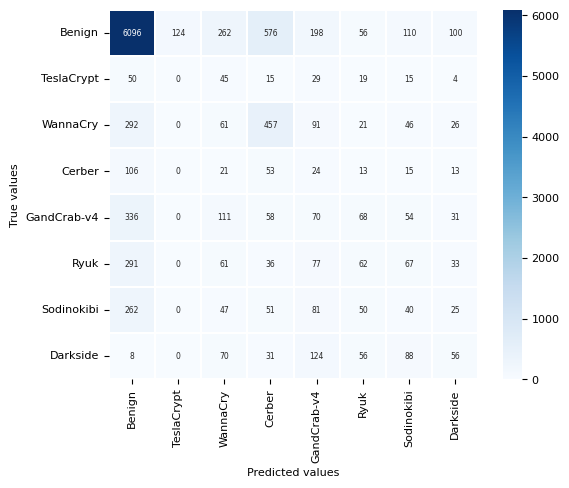

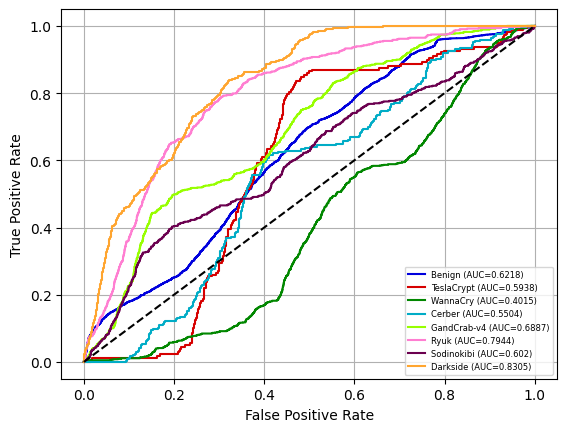

Test evaluation results: recall = 0.5706435029250133 , F1 = 0.5745788891508646 , acc = 0.5706435029250133 , precision = 0.583530083448401 auc = 0.6353875


In [ ]:
print("Retraining:")
pipeline_nsm2 = skPipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", random_state=0, max_iter=450, probability=True))])

pipeline_nsm2.fit(x_train, y_train)

visualizeResults(x_test, y_test, pipeline_nsm2)

# LDA

In [ ]:
# General
np.random.seed(1)

rkfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=45)
metrics = np.array([], dtype=np.int64).reshape(num_metrics,0)

for i, (train_index, val_index) in enumerate(rkfold.split(x_train, y_train)):
  pipeline_nsm = skPipeline([
     ("scaler", StandardScaler()),
     ("clf", LinearDiscriminantAnalysis())
  ])
  pipeline_nsm.fit(x_train[train_index],y_train[train_index])
  # Labels obtained
  ytrue = y_train[val_index]
  ypred = pipeline_nsm.predict(x_train[val_index])
  yproba = pipeline_nsm.predict_proba(x_train[val_index])
  # Calculate metrics
  result = calculateMetrics(ytrue, ypred, yproba, labels)
  metrics = np.hstack((metrics,result))

# Test
pipeline_nsm = skPipeline([
     ("scaler", StandardScaler()),
     ("clf", LinearDiscriminantAnalysis())
  ])
pipeline_nsm.fit(x_train,y_train)


------------------------------
Valores de métricas obtenidas:
------------------------------
precision: 0.6680762114391021
recall: 0.6680762114391021
f1-score: 0.6680762114391021
accuracy: 0.6680762114391021
error: 0.3319237885608979
specificity: 0.9525823159198717
false positive rate: 0.04741768408012825
auc: 0.70645
------------------------------
Valores de métricas obtenidas:
------------------------------
precision: 0.6679617243964502
recall: 0.6679617243964502
f1-score: 0.6679617243964502
accuracy: 0.6679617243964502
error: 0.3320382756035498
specificity: 0.9525659606280643
false positive rate: 0.04743403937193569
auc: 0.7067375
------------------------------
Valores de métricas obtenidas:
------------------------------
precision: 0.668090371067963
recall: 0.668090371067963
f1-score: 0.668090371067963
accuracy: 0.668090371067963
error: 0.331909628932037
specificity: 0.9525843387239947
false positive rate: 0.04741566127600527
auc: 0.7069625
------------------------------
Valores de

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LinearDiscriminantAnalysis())])

Classification report
              precision    recall  f1-score   support

           0       0.68      0.99      0.81    451299
           1       0.00      0.00      0.00     10632
           2       0.04      0.00      0.00     59631
           3       0.00      0.00      0.00     14676
           4       0.12      0.00      0.00     43710
           5       0.15      0.02      0.04     37602
           6       0.18      0.01      0.02     33382
           7       0.20      0.10      0.13     26000

    accuracy                           0.67    676932
   macro avg       0.17      0.14      0.13    676932
weighted avg       0.49      0.67      0.55    676932

             Benign  TeslaCrypt  WannaCry  Cerber  GandCrab-v4  Ryuk  \
Benign       448456           0       162       0           15  1377   
TeslaCrypt    10345           0        20       0            0    64   
WannaCry      57928           0        13       0            1   429   
Cerber        13537           0        

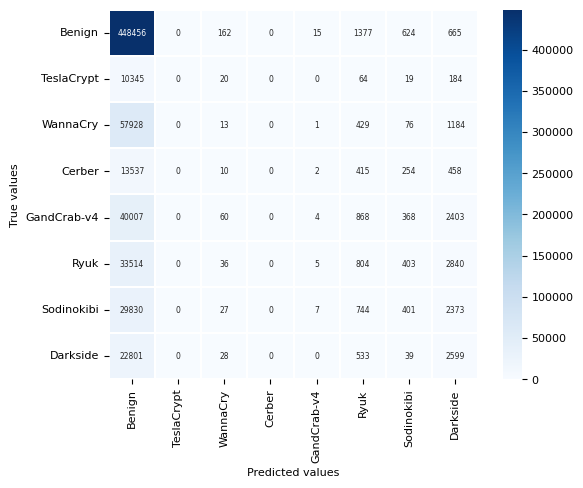

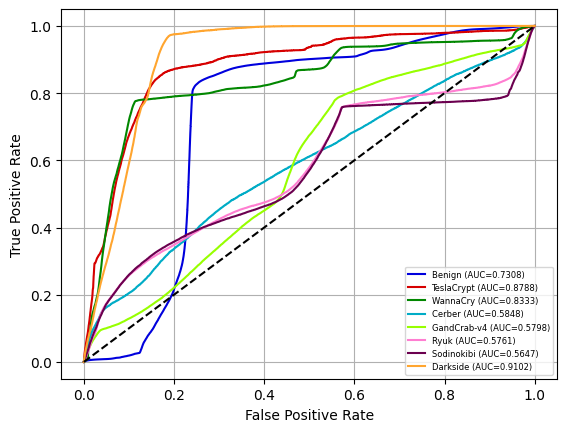

Test evaluation results: recall = 0.6681276701352573 , F1 = 0.5482145031059301 , acc = 0.6681276701352573 , precision = 0.4917257443208666 auc = 0.7073125


In [ ]:
visualizeResults(x_test, y_test, pipeline_nsm)

# Naive Bayes

In [ ]:
# General
np.random.seed(1)

rkfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=45)
metrics = np.array([], dtype=np.int64).reshape(num_metrics,0)

for i, (train_index, val_index) in enumerate(rkfold.split(x_train, y_train)):
  pipeline_nsm = skPipeline([
     ("scaler", StandardScaler()),
     ("clf", GaussianNB())
  ])
  pipeline_nsm.fit(x_train[train_index],y_train[train_index])
  # Labels obtained
  ytrue = y_train[val_index]
  ypred = pipeline_nsm.predict(x_train[val_index])
  yproba = pipeline_nsm.predict_proba(x_train[val_index])
  # Calculate metrics
  result = calculateMetrics(ytrue, ypred, yproba, labels)
  metrics = np.hstack((metrics,result))

# Test
pipeline_nsm = skPipeline([
     ("scaler", StandardScaler()),
     ("clf", GaussianNB())
  ])
pipeline_nsm.fit(x_train,y_train)


------------------------------
Valores de métricas obtenidas:
------------------------------
precision: 0.5874662540208957
recall: 0.5874662540208957
f1-score: 0.5874662540208957
accuracy: 0.5874662540208957
error: 0.4125337459791043
specificity: 0.9410666077172708
false positive rate: 0.0589333922827292
auc: 0.836275
------------------------------
Valores de métricas obtenidas:
------------------------------
precision: 0.5820484317121722
recall: 0.5820484317121722
f1-score: 0.5820484317121722
accuracy: 0.5820484317121722
error: 0.41795156828782776
specificity: 0.9402926331017389
false positive rate: 0.05970736689826106
auc: 0.8356750000000001
------------------------------
Valores de métricas obtenidas:
------------------------------
precision: 0.5541404684744573
recall: 0.5541404684744573
f1-score: 0.5541404684744573
accuracy: 0.5541404684744573
error: 0.4458595315255427
specificity: 0.9363057812106368
false positive rate: 0.06369421878936321
auc: 0.8326749999999999
-----------------

Pipeline(steps=[('scaler', StandardScaler()), ('clf', GaussianNB())])

Classification report
              precision    recall  f1-score   support

           0       0.77      0.72      0.74    451299
           1       0.19      0.16      0.17     10632
           2       0.28      0.71      0.40     59631
           3       0.00      0.00      0.00     14676
           4       0.28      0.16      0.20     43710
           5       0.01      0.00      0.00     37602
           6       0.00      0.00      0.00     33382
           7       0.20      0.52      0.29     26000

    accuracy                           0.57    676932
   macro avg       0.22      0.28      0.23    676932
weighted avg       0.56      0.57      0.56    676932

             Benign  TeslaCrypt  WannaCry  Cerber  GandCrab-v4  Ryuk  \
Benign       322984         347     94776       0         5498   386   
TeslaCrypt     6825        1655       703       0         1058     0   
WannaCry       9443         747     42617       0          526     0   
Cerber        10312         247      10

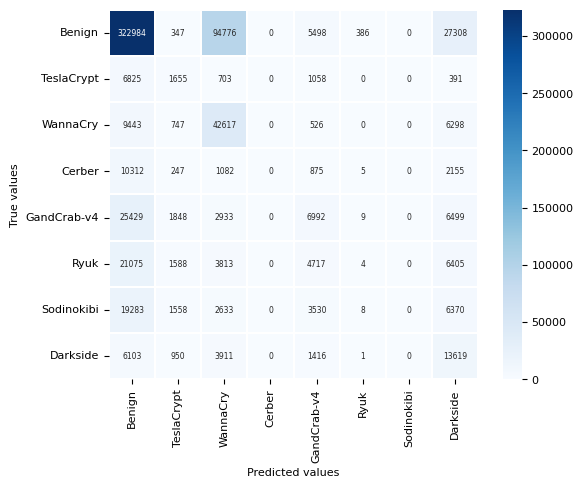

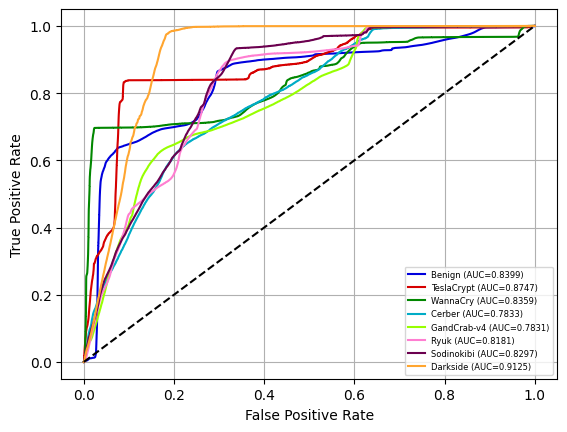

Test evaluation results: recall = 0.5729836970330846 , F1 = 0.555736334251995 , acc = 0.5729836970330846 , precision = 0.5649046418678532 auc = 0.83465


In [ ]:
visualizeResults(x_test, y_test, pipeline_nsm)